In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.engine import DDIMSampler
from utils.ema    import EMA
from model.UNet   import UNet

# 1) Point this to your trained checkpoint
checkpoint_path = "checkpoint/gedi_treecover_v5.pth"

# 2) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3) Load checkpoint
cp = torch.load(checkpoint_path, map_location=device)

# 4) Instantiate model & load raw weights
model = UNet(**cp["config"]["Model"]).to(device)
model.load_state_dict(cp["model"])
model.eval()

# 5) Build EMA helper and inject saved shadow weights
ema = EMA(model, decay=0.9999)
ema.shadow = {k: v.to(device) for k, v in cp["ema_shadow"].items()}

# 6) Swap in EMA weights
ema.store(model)    # backs up raw weights & copies EMA→model

# 7) Create sampler (will now use EMA-smoothed model)
guidance_scale = 1.0
sampler = DDIMSampler(
    model,
    guidance_scale=guidance_scale,
    **cp["config"]["Trainer"]
).to(device)

# 8) Sampling hyper-params
steps  = 500
eta    = 0.1
method = "quadratic"  # linear, quadratic

Sampling for condition 0.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 5.0...


100%|██████████| 500/500 [01:48<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 10.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 15.0...


100%|██████████| 500/500 [01:48<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 20.0...


100%|██████████| 500/500 [01:48<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 25.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 30.0...


100%|██████████| 500/500 [01:49<00:00,  4.58it/s, step=1, sample=1]  


Sampling for condition 35.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 40.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 45.0...


100%|██████████| 500/500 [01:48<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 50.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 55.0...


100%|██████████| 500/500 [01:48<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 60.0...


100%|██████████| 500/500 [01:48<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 65.0...


100%|██████████| 500/500 [01:48<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 70.0...


100%|██████████| 500/500 [01:49<00:00,  4.57it/s, step=1, sample=1]  


Sampling for condition 75.0...


100%|██████████| 500/500 [01:50<00:00,  4.52it/s, step=1, sample=1]  


Sampling for condition 80.0...


100%|██████████| 500/500 [01:49<00:00,  4.58it/s, step=1, sample=1]  


Sampling for condition 85.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 90.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


Sampling for condition 95.0...


100%|██████████| 500/500 [01:49<00:00,  4.58it/s, step=1, sample=1]  


Sampling for condition 100.0...


100%|██████████| 500/500 [01:49<00:00,  4.59it/s, step=1, sample=1]  


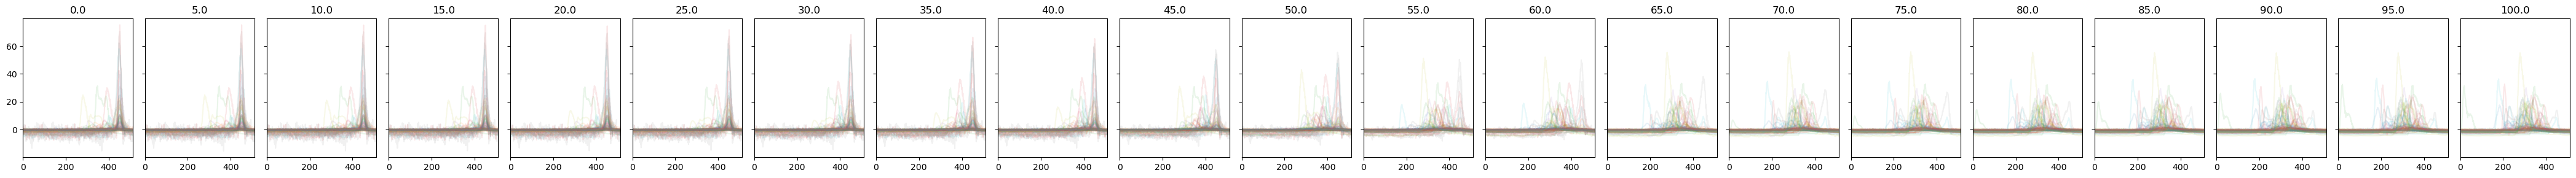

In [ ]:
from torch.amp import autocast

# 1) Define condition grid (0.0 → 1.0 in steps of 0.1)
cond_values = np.round(np.linspace(0.0, 1.0, 21), 2)

# 2) Batch size & storage dict
batch_size     = 120
waveform_dict  = {}

# 3) Prepare plotting grid
fig, axes = plt.subplots(
    nrows=1, ncols=len(cond_values),
    figsize=(len(cond_values)*2, 3),
    sharey=True
)
x_axis = np.arange(512)  # waveform length
z_t    = torch.randn((batch_size, cp["config"]["Model"]["in_channels"], 512),
                     device=device)
z_t = torch.clamp(z_t, min=0.0)  # clamp to [-1, 1] for model input


# 4) Loop through each condition with mixed precision
for i, cond in enumerate(cond_values):
    print(f"Sampling for condition {cond*100:.1f}...")
    cond_tensor = torch.full((batch_size, 1), cond,
                             dtype=torch.float, device=device)
    
    # run sampler under autocast for mixed precision
    with autocast('cuda', dtype=torch.bfloat16):
        x = sampler(
            z_t, cond=cond_tensor,
            only_return_x_0=True,
            steps=steps, eta=eta,
            method=method
        )

    # x: [B, 1, 512] → to numpy & squeeze channel
    waveforms = x.cpu().numpy().squeeze(1)  # (batch_size, 512)
    waveform_dict[cond] = waveforms

    # plot stacked waveforms
    ax = axes[i]
    for wf in waveforms:
        ax.plot(x_axis, wf, alpha=0.1)
    ax.set_title(f"{cond*100:.1f}")
    ax.set_xlim(0, 511)

plt.tight_layout()
plt.show()


In [27]:
plt.show()

In [28]:
import pickle

with open("waveform_dict.pkl", "wb") as f:
    pickle.dump(waveform_dict, f)
print("Saved all waveforms → waveform_dict.pkl")


Saved all waveforms → waveform_dict.pkl


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectionSlider

# Ensure waveform_dict is in memory;
# if starting fresh, load it:
# import pickle
# with open("waveform_dict.pkl","rb") as f:
#     waveform_dict = pickle.load(f)

conds = sorted(waveform_dict.keys())

def plot_for_cond(cond):
    wfs = waveform_dict[cond]  # shape (batch_size, 512)
    x  = np.arange(wfs.shape[1])
    plt.figure(figsize=(6, 4))
    for wf in wfs:
        plt.plot(x, wf, alpha=0.1)
    plt.title(f"Tree-cover = {cond*100:.1f}")
    plt.xlim(0, wfs.shape[1] - 1)
    plt.ylim(0, 80)
    plt.show()

slider = SelectionSlider(
    options=[float(c) for c in conds],
    description="Tree-cover",
    continuous_update=True
)
interact(plot_for_cond, cond=slider)


interactive(children=(SelectionSlider(description='Tree-cover', options=(0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.…

<function __main__.plot_for_cond(cond)>

In [ ]:
import imageio

images = []
for cond in conds:
    wfs = waveform_dict[cond]
    fig, ax = plt.subplots(figsize=(6, 4))
    for wf in wfs:
        ax.plot(x_axis, wf, alpha=0.1)
    ax.set_title(f"Tree-cover = {cond:.2f}")
    ax.set_xlim(0, wfs.shape[1] - 1)
    ax.set_ylim(0, 80)
    fig.canvas.draw()
    # get RGBA buffer from the Agg canvas and drop alpha
    buf = fig.canvas.buffer_rgba()
    img = np.asarray(buf)[:, :, :3]
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(img)
    plt.close(fig)

imageio.mimsave(f"waveforms_w{guidance_scale}_eta{eta}.gif", images, fps=4)
print("Saved animated GIF → waveforms.gif")

Saved animated GIF → waveforms.gif
